### Overview

The goal of this script is to build a model with maximum interpretability of features while achieving a cross validated prediction accuracy of no less than 25% lower than the best predictive model.

### Prediction Modeling Recap

- The model with the highest predictive ability was the gradient boosting classifier at 83.9 percent accuracy
- Twenty-five percent below 83.9 percent is 62.9 percent
- The logistic regression model with L1 penalty achieved an accuracy of 79.1 percent with median imputed values, well above 62.9 percent
- The logistic regression model also has the highest interpretability of all of the prediction models

### Import Libraries

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing
import sklearn.linear_model
import sklearn.ensemble
import sklearn.model_selection
import warnings
warnings.filterwarnings('ignore')
import wrangle #Custom scripts I created. See documentation.

### Retrieve Training and Test Data

In [51]:
#Load data
filepath1 = "Data/train.csv"
filepath2 = "Data/test.csv"
train = pd.read_csv(filepath1)
test = pd.read_csv(filepath2)

#Wrangle data
train = wrangle.wrangle(train)
test = wrangle.wrangle(test)

### Logistic Regression Model Feature Diagnostics

In [52]:
#Retrieve full y column for model fitting
y_full = train.Survived

#Drop PassengerId
train = train.drop(["Survived","PassengerId"],1)

#Imputation of missing values for training data
imp_median = sklearn.preprocessing.Imputer(missing_values='NaN', strategy='median', axis=0)
X_median = imp_median.fit_transform(train.iloc[:,:])

In [53]:
train.head(5)

,Pclass,Age,SibSp,Parch,Fare,Ticket_Num,Cabin_Yes,Cabin_C,Cabin_E,Cabin_A,...,Ticket_Prefix_SOP,Ticket_Prefix_SOPP,Ticket_Prefix_SOTONO2,Ticket_Prefix_SOTONOQ,Ticket_Prefix_SP,Ticket_Prefix_STONO 2,Ticket_Prefix_STONO2,Ticket_Prefix_SWPP,Ticket_Prefix_WC,Ticket_Prefix_WEP
0,3,22.0,1,0,7.2500,21171.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,38.0,1,0,71.2833,17599.0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,26.0,0,0,7.9250,3101282.0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,35.0,1,0,53.1000,113803.0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,35.0,0,0,8.0500,373450.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
log_cv = sklearn.linear_model.LogisticRegressionCV(cv = 10, solver ="liblinear", penalty = "l1", random_state = 100)
log_cv = log_cv.fit(X_median, y_full)

#C_ stores the regularization parameter
C = float(log_cv.C_)

In [55]:
# Subsampling and fitting a L1-penalized logsitic regression model using lambda (C) from previous CV model
# Assessing features selected from CV L1 model and percentage of time that feature is selected when repeatedly sampling with same C penalty
log_rand = sklearn.linear_model.RandomizedLogisticRegression(C = C, n_resampling=200, random_state = 100)
log_rand = log_rand.fit(X_median, y_full)

In [56]:
#Random forest classifier
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=100, max_features="sqrt", random_state = 100)
rf = rf.fit(X_median,y_full)

In [57]:
#Extremely randomized trees
ert = sklearn.ensemble.ExtraTreesClassifier(n_estimators=100, max_features="sqrt", random_state = 100)
ert = ert.fit(X_median,y_full)

In [58]:
#Gradient boosting classifier
gbc = sklearn.ensemble.GradientBoostingClassifier(learning_rate = 0.1, n_estimators=100, max_depth = 3, random_state = 100)
gbc = gbc.fit(X_median,y_full)

In [80]:
#Table of feature selection diagnostics
pd.DataFrame(list(zip(train.columns, 
                      np.transpose(log_cv.coef_),
                      np.transpose(log_rand.scores_))),columns=["Feature", 
                                                                       "L1Penalty", 
                                                                       "RandomScore"])

,Feature,L1Penalty,RandomScore
0,Pclass,[-0.877158267336],1.000
1,Age,[-0.0407302595751],0.990
2,SibSp,[-0.347929488643],0.845
3,Parch,[-0.124428543636],0.165
4,Fare,[0.00419921069747],0.335
5,Ticket_Num,[1.28347696257e-09],0.010
6,Cabin_Yes,[0.624638207209],0.810
7,Cabin_C,[-0.496568882845],0.090
8,Cabin_E,[1.24121428857],0.750
9,Cabin_A,[0.0],0.065


### Stability Selection Results

Ten features were selected over 70 percent of the time using subsampling of a L1 logistic regression model, with a penalty value of approximately 2.78.
- Ticket class
- Age
- Number of siblings and spouses aboard Titanic
- Cabin information recorded
- Cabin E
- Cabin D
- Female
- Male
- Ticket prefix "STONO 2"
- Ticket prefix "SWPP"
- Ticket prefix "WC"

### Feature Importance Results

In [60]:
#Table of feature selection diagnostics
feat_import = pd.DataFrame(list(zip(np.transpose(rf.feature_importances_),
                      np.transpose(ert.feature_importances_),
                      np.transpose(gbc.feature_importances_))),columns=["RandForest",
                                                                        "ExtrRandTree",
                                                                       "GradBoosClass"])
#Round feature importance values to 3 decimal places
vals = np.around(feat_import.values,3)

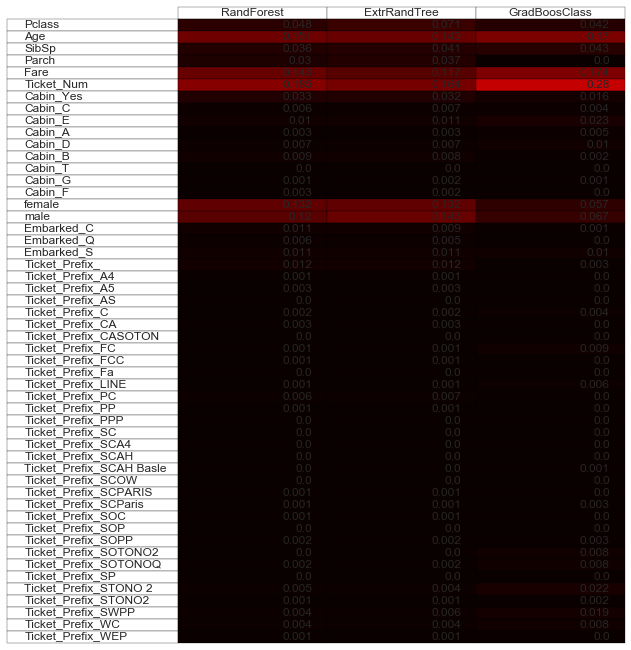

In [79]:
fig, ax = plt.subplots()

#Hide axes
ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False)

ax.table(cellText=vals, rowLabels=train.columns, colLabels=feat_import.columns,loc='center', 
                    cellColours=plt.cm.hot(vals))
plt.show()

Five important features stood out, based upon their ability to decrese Gini impurity in the model. It is critical to note that features with many different possible values and correlated features can have overweighted feature importance.
- Age
- Fare
- Ticket number
- Female
- Male

### Conclusion

- Overlap between stability selection results and feature importance includes age and sex. 
- The logistical regression model estimates Log-odds for females to be approxmiately 2.88 and -0.041 for each additional year of age. This means that being female increased odds of survival by over 17 times, while each addition year in age decreased the probability of survival by roughly 4 percent.
- Each additional sibling or spouse decreased the odds of survival by roughly 30 percent
- Having cabin information recorded increases the odd of survival by 80 percent
- Cabin E, and ticket prefixes "STONO 2" and "SWPP" increased the odds of survival by approximately 3.5, 9.5 and 56.8 times
- Ticket prefix "WC" decreases the odds of survival by roughly 70 percent


These features above provide a basis for comparing similar historical martime disasters. The policy of women and children first is noted to have been used during the sinking of the RMS Titanic. These estimates provide supporting evidence that this policy allowed more women and children to survive. The role of family size, cabin location, and ticket origination should be further investigated given their estimated impact on survival.